## Libraries

In [14]:
# Common:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
import resampy
import struct

# Features engineering:
from python_speech_features import mfcc, delta

# Keras tools:
import tensorflow as tf

# Sklearn tools:
from sklearn import model_selection, pipeline, preprocessing, metrics

# Graphics:
import matplotlib.pyplot as plt

## Common params and settings

In [42]:
# Paths:
TRAIN_FILE = 'C:/Users/Alex/Desktop/Untitled Folder/Features/train_features.csv'
REAL_SIGNAL = 'C:/Users/Alex/Desktop/Vega-VAD project/data/real/room.wav'

# Features:
SAMPLE_RATE = 16000
PREEMPHASIS_COEF = 0.95  # Coefficient for pre-processing filter
FRAME_LENGTH = 0.032  # Window length in sec
FRAME_STEP = 0.01  # Length of step in sec
WINDOW_FUNCTION = np.hamming  # Type of window function
NFFT = 512  # Points of FFT
NFILTERS = 26
CEPLIFTER = 22
APPEND_ENERGY = True
NFEATURES = 13  # Number of Mel filters

# Params for MLP classifier:
TEST_SIZE = 0.3
ACTIVATE_FUNCTION = 'relu'
SOLVER = 'adam'
BATCH_SIZE = 64
EPOCHS = 10
CALL_BACKS = None

## Importing data

In [3]:
# Load data set for training:
mfcc_features = pd.read_csv(TRAIN_FILE, header=None)
mfcc_features = np.array(mfcc_features)

labels = np.zeros((mfcc_features.shape[0]))
data_feat = np.zeros((mfcc_features.shape[0], mfcc_features.shape[1] - 1))
for i in range(mfcc_features.shape[0]):
    labels[i] = mfcc_features[i][0]
    data_feat[i][:] = mfcc_features[i][1:]

## Spliting data

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_feat,
                                                                    labels,
                                                                    test_size=TEST_SIZE,
                                                                    shuffle=True,
                                                                    random_state=1)

## Scaling data

In [76]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

## Building and fitting the model

In [77]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(X_train_scaled.shape[1], )))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [91]:
model.fit(X_train_scaled, y_train_cat,
          validation_data=(X_test_scaled, y_test_cat),
          epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=CALL_BACKS)

Epoch 1/10


TypeError: 'NoneType' object is not callable

## Performing prediction

In [69]:
def plot_roc_curve(fpr: np.ndarray, tpr: np.ndarray) -> None: 
    plt.plot(fpr, tpr)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [70]:
y_test_predicted_proba = model.predict(X_test).ravel()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predicted_proba)
auc_score = metrics.roc_auc_score(y_test, y_test_predicted_proba)
plot_roc_curve(fpr=fpr, tpr=tpr)


print(auc_score)

ValueError: Found input variables with inconsistent numbers of samples: [8832720, 17665440]

In [75]:
X_test.shape

(8832720, 39)

In [72]:
y_test_predicted_proba.shape

(17665440,)

In [73]:
y_test.shape

(8832720,)

In [74]:
y_test

array([0., 0., 0., ..., 1., 1., 0.])

## Performing test on the real signal

In [55]:
def getFeatures(sig: np.ndarray) -> np.ndarray:
    features = np.zeros((1, 3 * NFEATURES))
    
    mfcc_feats = mfcc(sig,
                      SAMPLE_RATE,
                      winlen=FRAME_LENGTH,
                      winstep=FRAME_STEP,
                      numcep=NFEATURES,
                      nfilt=NFILTERS,
                      nfft=NFFT,
                      lowfreq=0,
                      highfreq=None,
                      preemph=PREEMPHASIS_COEF,
                      ceplifter=CEPLIFTER,
                      appendEnergy=APPEND_ENERGY,
                      winfunc=WINDOW_FUNCTION)
    d_mfcc = delta(mfcc_feats, N=2)
    d2_mfcc = delta(d_mfcc, N=2)
    
    dataset_on_sample = np.zeros((mfcc_feats.shape[0], 3 * NFEATURES))
    for j in range(mfcc_feats.shape[0]):
        dataset_on_sample[j][:NFEATURES] = mfcc_feats[j][:]
        dataset_on_sample[j][NFEATURES:2 * NFEATURES] = d_mfcc[j][:]
        dataset_on_sample[j][2 * NFEATURES:3 * NFEATURES] = d2_mfcc[j][:]
        
    mfcc_feat = np.concatenate((features, dataset_on_sample), axis=0)
    mfcc_feat = np.delete(mfcc_feat, 0, axis=0)
    
    return mfcc_feat

In [56]:
# Get vector combined labels:
def combine_labels(sig: np.ndarray, labels: np.ndarray, frame_length: int, frame_step: int, sample_rate: int) -> np.ndarray:
    time_series_labels_speech = np.zeros(sig.shape[0])

    begin = 0
    end = int(frame_length * sample_rate)
    shift = int(frame_step * sample_rate)
    for i in range(labels.shape[0]):
        if labels[i] == 1:
            time_series_labels_speech[begin:end] = 1
        begin = begin + shift
        end = end + shift 

    return time_series_labels_speech

In [57]:
# Get plot:
def plot_result_VAD(sound: np.ndarray, labels: np.ndarray) -> None:
    plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(sound / max(abs(sound)), color='blue')
    plt.plot(labels, color='red')

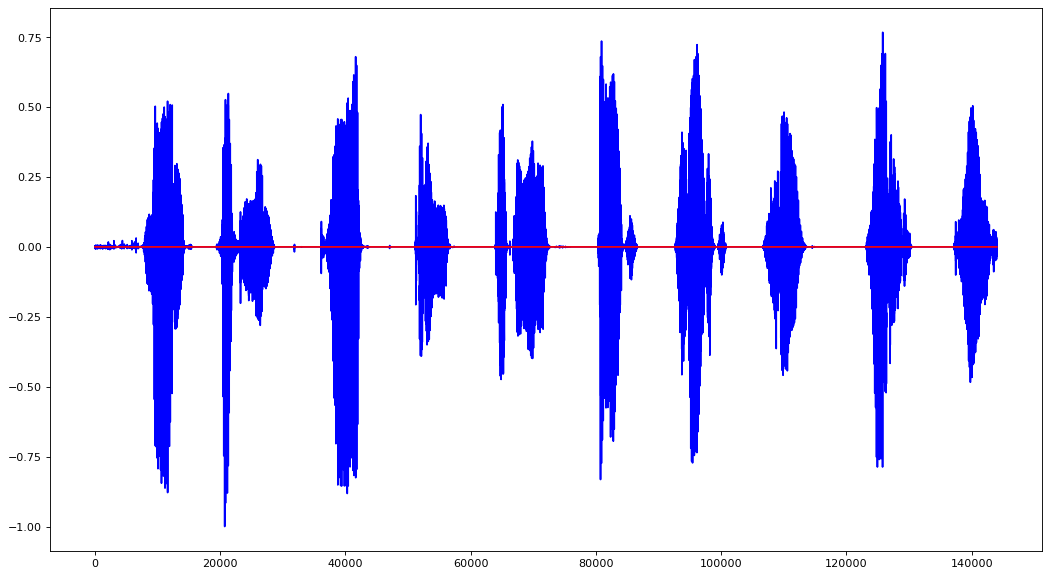

In [92]:
# Read the wav file:
(sample_rate, sig) = wav.read(REAL_SIGNAL)
sig = resampy.resample(x=sig, sr_orig=sample_rate, sr_new=SAMPLE_RATE)

features = getFeatures(sig=sig)
features_scaled = scaler.transform(features)
labels_MLPClassifier = model.predict(features_scaled)
labels_MLPClassifier_classes = labels_MLPClassifier.argmax(axis=-1)

op_MLPClassifier = combine_labels(sig=sig,
                                  labels=labels_MLPClassifier_classes,
                                  frame_length=FRAME_LENGTH,
                                  frame_step=FRAME_STEP,
                                  sample_rate=SAMPLE_RATE)
plot_result_VAD(sound=sig, labels=op_MLPClassifier)

## Getting DNN inner params

In [63]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'name': 'dense_32', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[ 0.10126778, -3.3467808 , -3.8670037 , ..., -3.0267868 ,
        -1.0941955 , -7.7413306 ],
       [ 0.22246547, -0.2782591 , -1.4359779 , ..., -1.5247875 ,
         0.10343505, -2.268572  ],
       [-1.0940241 ,  0.98869425, -3.729604  , ...,  0.31005993,
         0.2763939 , -0.76098084],
       ...,
       [-0.7526406 , -0.21937701, -0.60358715, ...,  0.33108306,
        -0.12470544,  0.77611107],
       [-0.24346064,  0.320667  ,  0.6679245 , ..., -1.7080511 ,
        -0.24884133, -0.36782447],
       [ 0.14536056, -0.29764187, -0.48771843, ..., -0.8503064 ,
        -0.12294309,  0.32894722

In [64]:
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_biases  = model.layers[0].get_weights()[1]
second_layer_weights = model.layers[1].get_weights()[0]
second_layer_biases  = model.layers[1].get_weights()[1]

# Linear SVM

In [6]:
clf_LSVC = make_pipeline(StandardScaler(), LinearSVC(random_state=0, max_iter=50000, tol=1e-5)).fit(X_train, y_train)

In [7]:
labels_LSVC = clf_LSVC.predict(mfcc_feat)

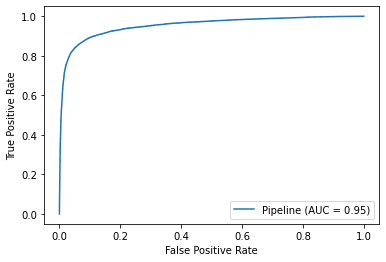

In [8]:
plot_roc_curve(clf_LSVC, X_test, y_test)

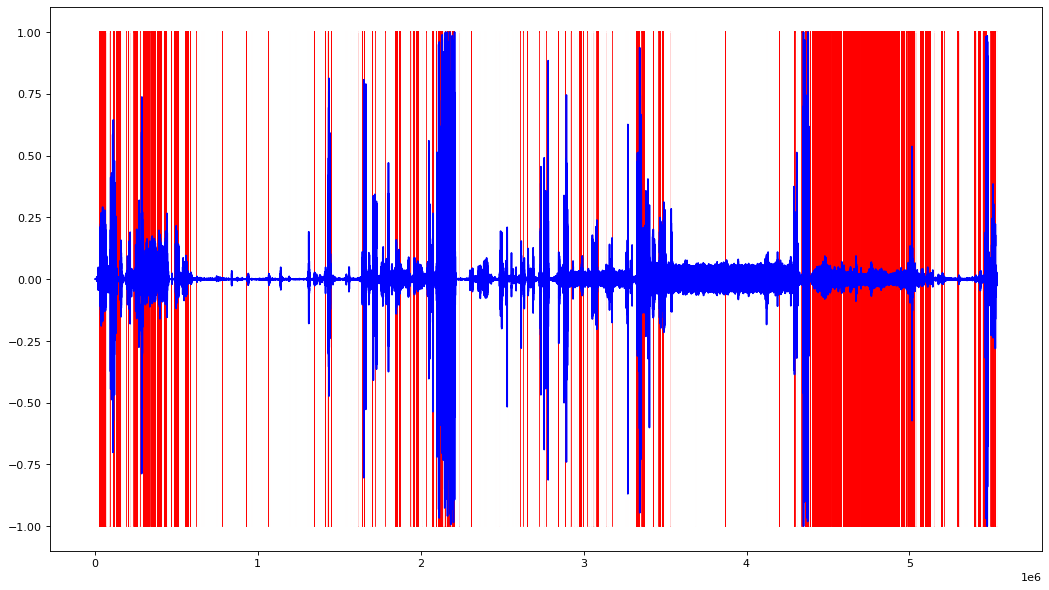

In [9]:
op_LSVC = combine_labels(mfcc_feat, labels_LSVC, sample_rate)
plot_result_VAD(sound, op_LSVC[2], op_LSVC[0], op_LSVC[1], op_LSVC[3])

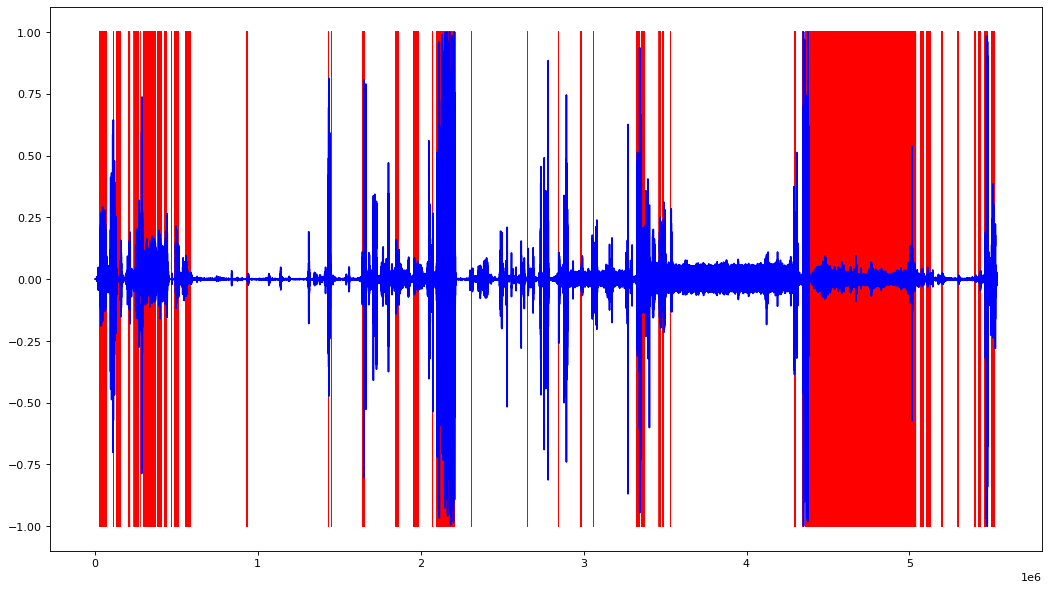

In [10]:
labels_LSVC_new = medfilt(labels_LSVC, 51)
op_LSVC_new = combine_labels(mfcc_feat, labels_LSVC_new, sample_rate)
plot_result_VAD(sound, op_LSVC_new[2], op_LSVC_new[0], op_LSVC_new[1], op_LSVC_new[3])

In [11]:
clf_LSVC[1].coef_

array([[ 0.42312113,  0.55581767,  0.15499356,  0.32318509, -0.28367759,
        -0.12808963,  0.00715227,  0.02969692, -0.07958695, -0.02682161,
        -0.23189075, -0.19653115, -0.09467366, -0.0427234 , -0.0017646 ,
        -0.01982936, -0.00530833, -0.01035294,  0.00941022, -0.028494  ,
         0.00276689,  0.00891517,  0.01957693, -0.01280737,  0.02665126,
        -0.00388747,  0.10956189,  0.11640333,  0.04731162,  0.11674034,
        -0.11838895, -0.06489317,  0.01071915,  0.01949375, -0.04095057,
        -0.00704833, -0.11448222, -0.10295135, -0.05208734]])

In [12]:
clf_LSVC[1].intercept_

array([-1.67498369])

In [14]:
clf_LSVC.predict(mfcc_feat[700].reshape(1, -1))

array([1.])

In [84]:
#test_input = np.linspace(39, 77, 39)
#test_input = np.linspace(0, 38, 39)
test_input = np.linspace(78, 116, 39)
#(test_input - u) / s
scaled_test_input = clf_LSVC[0].transform(test_input.reshape(1, -1))
scaled_test_input

array([[ 19.74972839,   5.92876154,   7.08991808,   6.08284463,
          4.60931   ,   5.27525969,   5.27824685,   5.88213696,
          6.53521535,   6.69079198,   7.48089929,   7.7197619 ,
          8.10136641, 244.67947656,  44.94509246,  42.53553536,
         42.0648654 ,  35.84037605,  33.1262905 ,  32.99054972,
         33.84744274,  33.23803803,  34.06760818,  35.6060083 ,
         36.68569345,  38.85797873, 695.20042019, 130.4391887 ,
        117.3050336 , 116.12064383,  98.36434754,  89.233173  ,
         86.95303049,  88.20511567,  86.30797431,  87.79651725,
         91.55174248,  93.82600453,  99.1190978 ]])

In [85]:
test_input

array([ 78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116.])

In [86]:
clf_LSVC[1].coef_

array([[ 3.22767762e-01,  4.06085702e-01,  3.62539964e-01,
         2.13799276e-01, -3.95264931e-01, -2.92230974e-01,
        -3.51347670e-01, -1.09742292e-01, -4.07794836e-02,
         1.11297836e-01,  2.24575034e-02, -9.96415060e-03,
        -2.10568745e-01,  2.65349056e-03, -6.31265294e-03,
        -8.22606863e-03, -3.53202845e-03,  4.28434115e-03,
         4.12582744e-04,  3.36996175e-03,  1.84148614e-03,
        -6.00567607e-03, -1.18367130e-04,  6.13558070e-03,
        -5.57281203e-03,  4.04300012e-03,  1.06021551e-01,
         1.65016193e-01,  1.36318226e-01,  9.82143796e-02,
        -1.38099307e-01, -1.28877125e-01, -1.40444681e-01,
        -4.66569949e-02, -2.69032745e-02,  4.83070666e-02,
         6.39746827e-03, -3.65467595e-03, -1.10618137e-01]])

In [87]:
clf_LSVC.predict(scaled_test_input)

array([1.])

In [88]:
summ = 0
for i in range(len(scaled_test_input[0])):
    summ = summ + scaled_test_input[0][i] * clf_LSVC[1].coef_[0][i]
    print(summ)

6.374575630280597
8.78216092078479
11.352539565797748
12.653047341852835
10.831148745833705
9.289554465841958
7.435054736889684
6.789535544389963
6.523032837119927
7.267703503244188
7.435705824779508
7.358784954615152
5.652890398928283
6.3021450809368
6.018422310843037
5.6685220778063385
5.519947776292215
5.67350017440909
5.687167510234546
5.798344401055405
5.860673997725113
5.661057108222766
5.6570246232155785
5.875488160416924
5.671045686805524
5.828148499416175
79.53437544102628
101.05895379170917
117.04976783908351
128.45448482641055
114.87043659157455
103.37032177344909
91.15823114872012
87.04284551518127
84.7208783928217
88.9620705983248
89.54776996601828
89.20486632363539
78.24049638304771


In [89]:
u = clf_LSVC[0].mean_
s = clf_LSVC[0].scale_
new_mfcc_feat = (mfcc_feat[700] - u) / s

In [90]:
np.dot(clf_LSVC[1].coef_, scaled_test_input.T) + clf_LSVC[1].intercept_

array([[77.87291885]])

In [91]:
clf_LSVC[1].intercept_

array([-0.36757753])

In [92]:
np.dot(clf_LSVC[1].coef_, scaled_test_input.T)

array([[78.24049638]])

In [27]:
clf_LSVC[1].coef_[0]

array([ 3.22767762e-01,  4.06085702e-01,  3.62539964e-01,  2.13799276e-01,
       -3.95264931e-01, -2.92230974e-01, -3.51347670e-01, -1.09742292e-01,
       -4.07794836e-02,  1.11297836e-01,  2.24575034e-02, -9.96415060e-03,
       -2.10568745e-01,  2.65349056e-03, -6.31265294e-03, -8.22606863e-03,
       -3.53202845e-03,  4.28434115e-03,  4.12582744e-04,  3.36996175e-03,
        1.84148614e-03, -6.00567607e-03, -1.18367130e-04,  6.13558070e-03,
       -5.57281203e-03,  4.04300012e-03,  1.06021551e-01,  1.65016193e-01,
        1.36318226e-01,  9.82143796e-02, -1.38099307e-01, -1.28877125e-01,
       -1.40444681e-01, -4.66569949e-02, -2.69032745e-02,  4.83070666e-02,
        6.39746827e-03, -3.65467595e-03, -1.10618137e-01])

In [28]:
def float_to_hex(f):
    return hex(struct.unpack('<I', struct.pack('<f', f))[0])

list_hex = []
for i in range(len(clf_LSVC[1].coef_[0])):
    list_hex.append(float_to_hex(clf_LSVC[1].coef_[0][i]))

In [29]:
list_strings = []
for i in range(39):
    list_strings.append("assign weights_SVM[" + str(i) + "] = 32'h" + str(list_hex[i][2:]) + ";")

In [30]:
list_strings

["assign weights_SVM[0] = 32'h3ea541d1;",
 "assign weights_SVM[1] = 32'h3ecfea77;",
 "assign weights_SVM[2] = 32'h3eb99ed7;",
 "assign weights_SVM[3] = 32'h3e5aee33;",
 "assign weights_SVM[4] = 32'hbeca602a;",
 "assign weights_SVM[5] = 32'hbe959f4c;",
 "assign weights_SVM[6] = 32'hbeb3e3d7;",
 "assign weights_SVM[7] = 32'hbde0c091;",
 "assign weights_SVM[8] = 32'hbd270863;",
 "assign weights_SVM[9] = 32'h3de3f01f;",
 "assign weights_SVM[10] = 32'h3cb7f8cc;",
 "assign weights_SVM[11] = 32'hbc2340ad;",
 "assign weights_SVM[12] = 32'hbe579f55;",
 "assign weights_SVM[13] = 32'h3b2de62f;",
 "assign weights_SVM[14] = 32'hbbceda5f;",
 "assign weights_SVM[15] = 32'hbc06c6a2;",
 "assign weights_SVM[16] = 32'hbb67799b;",
 "assign weights_SVM[17] = 32'h3b8c63a9;",
 "assign weights_SVM[18] = 32'h39d84feb;",
 "assign weights_SVM[19] = 32'h3b5cda94;",
 "assign weights_SVM[20] = 32'h3af15e05;",
 "assign weights_SVM[21] = 32'hbbc4cb43;",
 "assign weights_SVM[22] = 32'hb8f83bde;",
 "assign weights_SVM[

# NuSVM

In [ ]:
clf_NuSVC = make_pipeline(StandardScaler(), NuSVC(nu=0.1, gamma='auto', random_state=42)).fit(X_train[:30000], y_train[:30000])

In [ ]:
labels_NuSVC = clf_NuSVC.predict(mfcc_feat)

In [ ]:
plot_roc_curve(clf_NuSVC, X_test, y_test)

In [ ]:
op_NuSVC = combine_labels(mfcc_feat, labels_NuSVC, sample_rate)
plot_result_VAD(sound, op_NuSVC[2], op_NuSVC[0], op_NuSVC[1], op_NuSVC[3])

In [ ]:
labels_NuSVC_new = medfilt(labels_NuSVC, 51)
op_NuSVC_new = combine_labels(mfcc_feat, labels_NuSVC_new, sample_rate)
plot_result_VAD(sound, op_NuSVC_new[2], op_NuSVC_new[0], op_NuSVC_new[1], op_NuSVC_new[3])

# Neural Net

In [11]:
clf_MLP = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', alpha=0.01, random_state=42, max_iter=1000).fit(X_train, y_train)

In [12]:
labels_MLP = clf_MLP.predict(mfcc_feat)

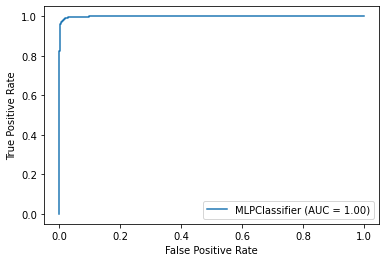

In [13]:
plot_roc_curve(clf_MLP, X_test, y_test)

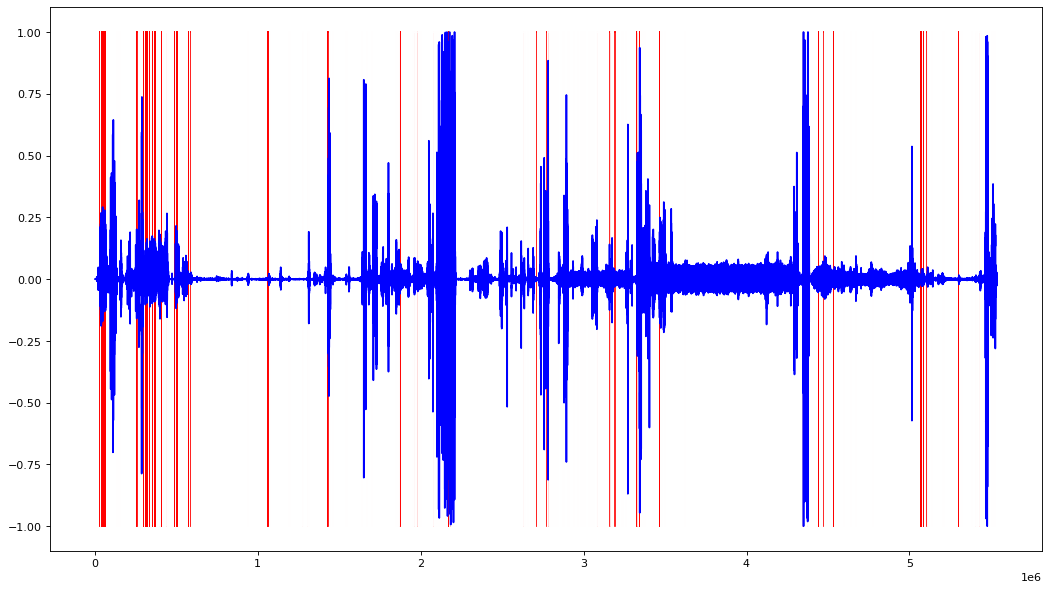

In [14]:
op_MLP = combine_labels(mfcc_feat, labels_MLP, sample_rate)
plot_result_VAD(sound, op_MLP[2], op_MLP[0], op_MLP[1], op_MLP[3])

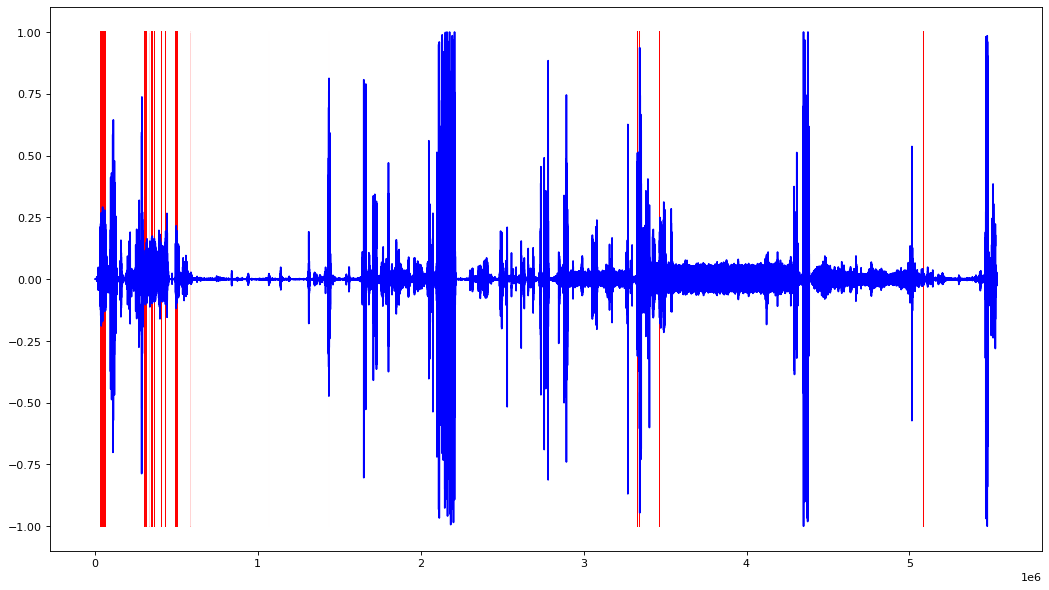

In [15]:
labels_MLP_new = medfilt(labels_MLP, 51)
op_MLP_new = combine_labels(mfcc_feat, labels_MLP_new, sample_rate)
plot_result_VAD(sound, op_MLP_new[2], op_MLP_new[0], op_MLP_new[1], op_MLP_new[3])

# labels

697758 341582


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([697757.5       , 697757.50000293, 697757.50000586, ...,
        697758.49999414, 697758.49999707, 697758.5       ]),
 <a list of 341582 Patch objects>)

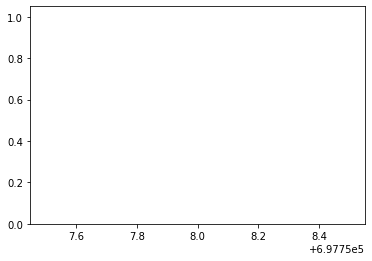

In [33]:
count_ones = 0
for i in range(len(labels)):
    if labels[i] == 1:
        count_ones = count_ones + 1
        
count_zeros = len(labels) - count_ones

print(count_zeros, count_ones)

In [39]:
# 1-d:
def write_1d(input_vec, filename):
    txt_list = []
    for i in range(len(input_vec)):
        if i == 0:
            txt_list.append('{ ')
        txt_list.append(str(input_vec[i]))
        if i == len(input_vec) - 1:
            txt_list.append(' },')
        else:
            txt_list.append(', ')
        
    f = open(filename, 'w')
    f.writelines(txt_list)
    f.close()

In [40]:
# 2-d:
def write_2d(input_vec, filename):
    txt_list = []
    for i in range(input_vec.shape[0]):
        for j in range(input_vec.shape[1]):
            if j == 0:
                txt_list.append('{ ')
            txt_list.append(str(input_vec[i][j]))
            if j == input_vec.shape[1] - 1:
                txt_list.append(' },')
            else:
                txt_list.append(', ')
                
    f = open(filename, 'w')
    f.writelines(txt_list)
    f.close()

In [41]:
write_1d(mfcc_feat[0], 'test_input.txt')
write_1d(np.linspace(0, 38, 39), 'test_input_counter.txt')
write_1d(clf_MLP.coefs_[1], 'coefs_second.txt')
write_1d(clf_MLP.intercepts_[0], 'intercepts_first.txt')

In [42]:
write_2d(clf_MLP.coefs_[0], 'coefs_first.txt')

In [43]:
clf_MLP.intercepts_[1]

array([-1.88764714])

In [44]:
a = np.array([10, 11, 12, 6, 3, 2, 6, 8, 1, 4, 6, 7, 8, 3, 1, 5, 78, 52, 5, 6, 7, 52])
b = medfilt(a, 3)

In [45]:
b

array([10., 11., 11.,  6.,  3.,  3.,  6.,  6.,  4.,  4.,  6.,  7.,  7.,
        3.,  3.,  5., 52., 52.,  6.,  6.,  7.,  7.])

In [2]:
kernel_size = 41
test = np.linspace(0, kernel_size - 1, kernel_size)

In [4]:
medfilt(test, kernel_size)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20.])